In [358]:
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from sklearn.frozen import FrozenEstimator
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.calibration import calibration_curve
import shap


# Helper Functions

For Data Preprocessing

In [359]:
def is_home(matchup):
    return int("@" not in matchup)

def is_win(result):
    return int("L" not in result)

def sort_by_date(df):
    return df.sort_values(by='GAME_DATE')

# Data Preprocessing

In [360]:
nba_player_data_2025_26 = pd.read_csv('out/player_stats_2025-26.csv')
nba_player_data_2024_25 = pd.read_csv('out/player_stats_2024-25.csv')
nba_players = pd.read_csv('out/players.csv')
nba_teams = pd.read_csv('out/teams.csv')
nba_season_games_2024_25 = pd.read_csv('out/season_games_2024-25.csv')
nba_season_games_2025_26 = pd.read_csv('out/season_games_2025-26.csv')


In [361]:
game_data_list = [nba_player_data_2025_26, nba_player_data_2024_25, nba_season_games_2024_25, nba_season_games_2025_26]
team_data_list = [nba_season_games_2024_25, nba_season_games_2025_26]

Add another feature for home game and non-home game

In [362]:
for data in game_data_list:
    data["IS_HOME"] = data["MATCHUP"].apply(is_home)

Sort each game by date

In [363]:
sort_by_list = ["TEAM_ID", "GAME_DATE"]
for data in game_data_list:
    data.sort_values(by=sort_by_list, inplace=True)

In [364]:
for data in game_data_list:
    data["WL"] = data["MATCHUP"].apply(is_win)

    #Effective field goal percentage
    data["EFG"] = (data["FGM"] + 0.5 * data["FG3M"]) / data["FGA"]

    #True shooting percentage
    data["TS"] = data["PTS"] / (2 * (data["FGA"] + 0.44 * data["FTA"]))

    #Assist to turnover ratio
    data["ast_tov"] = data["AST"] / (data["TOV"] + 1e-8)  # Add small value to avoid division by zero)

    #Turnover rate
    data["tov_rate"] = data["TOV"] / (data["FGA"] + 0.44 * data["FTA"] + 1e-8) # Add small value to avoid division by zero

    #offensive rebound rate
    data["oreb_rate"] = data["OREB"] / (data["OREB"] + data["DREB"] + 1e-8) # Add small value to avoid division by zero

    #stealing and blocks
    data["stocks"] = data["STL"] + data["BLK"]

    #Personal fouls rate
    data["pf_rate"] = data["PF"] / (data["MIN"] + 1e-8) # Add small value to avoid division by zero


Calculates win percentages from previous games and add a column for it

In [365]:
nba_season_games_2024_25["wins_so_far"] = (
    nba_season_games_2024_25.groupby("TEAM_ID")["WL"]
      .shift(1)
      .cumsum()
)

nba_season_games_2024_25["games_so_far"] = (
    nba_season_games_2024_25.groupby("TEAM_ID")["WL"]
      .cumcount()
)

nba_season_games_2024_25["win_percentage"] = (
    nba_season_games_2024_25["wins_so_far"] / nba_season_games_2024_25["games_so_far"]
)


nba_season_games_2025_26["wins_so_far"] = (
    nba_season_games_2025_26.groupby("TEAM_ID")["WL"]
      .shift(1)
      .cumsum()
)

nba_season_games_2025_26["games_so_far"] = (
    nba_season_games_2025_26.groupby("TEAM_ID")["WL"]
      .cumcount()
)


nba_season_games_2025_26["win_percentage"] = (
    nba_season_games_2025_26["wins_so_far"] / nba_season_games_2025_26["games_so_far"]
)

Gets winrate of last 5 and 10 games

In [366]:
nba_season_games_2024_25["win_percentage_last_5"] = (
    nba_season_games_2024_25.groupby("TEAM_ID")["WL"]
      .shift(1)
      .rolling(window=5, min_periods=1)
      .mean()
)

nba_season_games_2025_26["win_percentage_last_5"] = (
    nba_season_games_2025_26.groupby("TEAM_ID")["WL"]
      .shift(1)
      .rolling(window=5, min_periods=1)
      .mean()
)

nba_season_games_2024_25["win_percentage_last_10"] = (
    nba_season_games_2024_25.groupby("TEAM_ID")["WL"]
      .shift(1)
      .rolling(window=10, min_periods=1)
      .mean()
)

nba_season_games_2025_26["win_percentage_last_10"] = (
    nba_season_games_2025_26.groupby("TEAM_ID")["WL"]
      .shift(1)
      .rolling(window=10, min_periods=1)
      .mean()
)



Gets the EWM (Exponential weighted moving average)

In [367]:
stat_list = ["WL", "PTS", "EFG", "TS", "ast_tov", "tov_rate", "oreb_rate", "stocks", "pf_rate"]
for data in team_data_list:
    for stat in stat_list:
        data[f"{stat}_ewm_5"] = (
            data.groupby("TEAM_ID")[stat]
                .shift(1)
                .ewm(span=5, min_periods=1)
                .mean()
        )
        data[f"{stat}_ewm_10"] = (
            data.groupby("TEAM_ID")[stat]
                .shift(1)
                .ewm(span=10, min_periods=1)
                .mean()
        )


In [368]:
for data in team_data_list:
    data["winstreak"] = (
        data.groupby("TEAM_ID")["WL"]
          .shift(1)
          .groupby(data["TEAM_ID"])
          .transform(lambda x: x.groupby((x != 1).cumsum()).cumcount())

    ).clip(-0.1,0.1)

Add opponent stats for column

In [369]:
for i, data in enumerate(team_data_list):
    opp = data[[
        "GAME_ID",
        "GAME_DATE",
        "TEAM_ID",
        "WL_ewm_10",
        "PTS_ewm_10",
        "EFG_ewm_10",
        "TS_ewm_10",
        "ast_tov_ewm_10",
        "tov_rate_ewm_10",
        "oreb_rate_ewm_10",
        "stocks_ewm_10",
        "pf_rate_ewm_10"
    ]].copy()

    opp = opp.rename(columns={
        "TEAM_ID": "OPP_TEAM_ID",
        "WL_ewm_10": "OPP_WL_ewm_10",
        "PTS_ewm_10": "OPP_PTS_ewm_10",
        "EFG_ewm_10": "OPP_EFG_ewm_10",
        "TS_ewm_10": "OPP_TS_ewm_10",
        "ast_tov_ewm_10": "OPP_ast_tov_ewm_10",
        "tov_rate_ewm_10": "OPP_tov_rate_ewm_10",
        "oreb_rate_ewm_10": "OPP_oreb_rate_ewm_10",
        "stocks_ewm_10": "OPP_stocks_ewm_10",
        "pf_rate_ewm_10": "OPP_pf_rate_ewm_10"
    })

    merged = data.merge(
        opp,
        on=["GAME_ID", "GAME_DATE"]
    )


    # remove self-joins
    merged = merged[merged["TEAM_ID"] != merged["OPP_TEAM_ID"]]

    team_data_list[i] = merged

In [370]:
team_data_list[0]

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,OPP_TEAM_ID,OPP_WL_ewm_10,OPP_PTS_ewm_10,OPP_EFG_ewm_10,OPP_TS_ewm_10,OPP_ast_tov_ewm_10,OPP_tov_rate_ewm_10,OPP_oreb_rate_ewm_10,OPP_stocks_ewm_10,OPP_pf_rate_ewm_10
1,12024,15020,NZB,New Zealand Breakers,12400002,2024-10-04,NZB @ UTA,1,239,87,...,1610612762,8.091118e-01,112.194586,0.514353,0.535922,2.584232,0.123254,0.309704,13.717537,0.077591
3,12024,15020,NZB,New Zealand Breakers,12400011,2024-10-07,NZB @ PHI,1,241,84,...,1610612755,9.159657e-01,111.087163,0.536319,0.578076,1.842358,0.156219,0.228867,15.958701,0.096228
5,12024,15020,NZB,New Zealand Breakers,12400029,2024-10-10,NZB @ OKC,1,241,89,...,1610612760,8.064396e-01,111.168289,0.539402,0.557824,2.082285,0.141404,0.219202,13.173587,0.080705
7,12024,15025,ULM,Ratiopharm Ulm,12400060,2024-10-16,ULM @ POR,0,240,100,...,1610612757,7.404152e-01,106.916484,0.521748,0.552890,1.859084,0.153963,0.268965,13.857684,0.074961
9,12024,1610612737,ATL,Atlanta Hawks,12400018,2024-10-08,ATL vs. IND,0,240,131,...,1610612754,1.159409e-08,102.864793,0.511793,0.542944,2.085918,0.121904,0.255449,12.758887,0.084848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,32024,1610616855,TMC,Team C,32400004,2025-02-14,TMC vs. TMT,1,73,40,...,1610616856,9.794662e-01,52.813069,0.583797,0.603161,2.802200,0.135642,0.322162,5.659690,0.025405
5596,32024,1610616856,TMT,Team T,32400004,2025-02-14,TMT @ TMC,1,73,34,...,1610616855,9.794662e-01,52.813069,0.583797,0.603161,2.802200,0.135642,0.322162,5.659690,0.025405
5599,32024,1610616857,TMM,Team M,32400005,2025-02-14,TMM vs. TMG,1,72,39,...,1610616858,9.794662e-01,52.813069,0.583797,0.603161,2.802200,0.135642,0.322162,5.659690,0.025405
5600,32024,1610616858,TMG,Team G League,32400005,2025-02-14,TMG @ TMM,1,73,40,...,1610616857,9.794662e-01,52.813069,0.583797,0.603161,2.802200,0.135642,0.322162,5.659690,0.025405


Calculate the differences and add them to the columns

In [371]:
subtract_stat_list = ["WL_ewm_10", "PTS_ewm_10", "EFG_ewm_10", "TS_ewm_10", "ast_tov_ewm_10", "tov_rate_ewm_10", "oreb_rate_ewm_10", "stocks_ewm_10", "pf_rate_ewm_10"]
for data in team_data_list:
    for stat in subtract_stat_list:
        if stat == "WL_ewm_10":
            data[f"{stat}_diff"] = (data[stat] - data[f"OPP_{stat}"]).clip(-0.1,0.1)
        else:
            data[f"{stat}_diff"] = data[stat] - data[f"OPP_{stat}"]

In [372]:
team_data_list[0]

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,OPP_pf_rate_ewm_10,WL_ewm_10_diff,PTS_ewm_10_diff,EFG_ewm_10_diff,TS_ewm_10_diff,ast_tov_ewm_10_diff,tov_rate_ewm_10_diff,oreb_rate_ewm_10_diff,stocks_ewm_10_diff,pf_rate_ewm_10_diff
1,12024,15020,NZB,New Zealand Breakers,12400002,2024-10-04,NZB @ UTA,1,239,87,...,0.077591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12024,15020,NZB,New Zealand Breakers,12400011,2024-10-07,NZB @ PHI,1,241,84,...,0.096228,0.084034,-24.087163,-0.111588,-0.137436,-0.404858,0.005856,0.142562,0.041299,-0.012546
5,12024,15020,NZB,New Zealand Breakers,12400029,2024-10-10,NZB @ OKC,1,241,89,...,0.080705,0.100000,-25.818289,-0.134384,-0.095233,-1.132910,0.057388,0.107619,1.176413,0.011724
7,12024,15025,ULM,Ratiopharm Ulm,12400060,2024-10-16,ULM @ POR,0,240,100,...,0.074961,0.100000,-21.566484,-0.116730,-0.090300,-0.909709,0.044829,0.057856,0.492316,0.017468
9,12024,1610612737,ATL,Atlanta Hawks,12400018,2024-10-08,ATL vs. IND,0,240,131,...,0.084848,0.100000,-17.514793,-0.106775,-0.080354,-1.136543,0.076888,0.071371,1.591113,0.007581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,32024,1610616855,TMC,Team C,32400004,2025-02-14,TMC vs. TMT,1,73,40,...,0.025405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5596,32024,1610616856,TMT,Team T,32400004,2025-02-14,TMT @ TMC,1,73,34,...,0.025405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5599,32024,1610616857,TMM,Team M,32400005,2025-02-14,TMM vs. TMG,1,72,39,...,0.025405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5600,32024,1610616858,TMG,Team G League,32400005,2025-02-14,TMG @ TMM,1,73,40,...,0.025405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []
seaon_id_2024_25 = team_data_list[0]["SEASON_ID"].unique()
season_id_2025_26 = team_data_list[1]["SEASON_ID"].unique()


for data in team_data_list:
    features = [
        # "WL_ewm_10_diff",
        "PTS_ewm_10_diff",
        "EFG_ewm_10_diff",
        "TS_ewm_10_diff",
        "ast_tov_ewm_10_diff",
        "tov_rate_ewm_10_diff",
        "oreb_rate_ewm_10_diff",
        "stocks_ewm_10_diff",
        "pf_rate_ewm_10_diff",
        "PTS_ewm_10",
        "EFG_ewm_10",
        "TS_ewm_10",
        "ast_tov_ewm_10",
        "tov_rate_ewm_10",
        "oreb_rate_ewm_10",
        "stocks_ewm_10",
        "pf_rate_ewm_10",
        "IS_HOME",
    ]
    target = "WL"

    train_mask = data["SEASON_ID"].isin(seaon_id_2024_25)
    test_mask  = data["SEASON_ID"].isin(season_id_2025_26)

    X_train_list.append(data.loc[train_mask, features])
    y_train_list.append(data.loc[train_mask, target])

    X_test_list.append(data.loc[test_mask, features])
    y_test_list.append(data.loc[test_mask, target])

# Model Training

In [349]:
X_train = pd.concat(X_train_list, ignore_index=True)
y_train = pd.concat(y_train_list, ignore_index=True)

mid = len(X_test_list) // 2
X_test_list = X_test_list[mid:]
y_test_list = y_test_list[mid:]

X_val_list = X_test_list[:mid]
y_val_list = y_test_list[:mid]

X_test = pd.concat(X_test_list, ignore_index=True)
y_test = pd.concat(y_test_list, ignore_index=True)

X_val = pd.concat(X_val_list, ignore_index=True)
y_val = pd.concat(y_val_list, ignore_index=True)


In [350]:
model = XGBClassifier(
    n_estimators=600,
    max_depth=3,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    early_stopping_rounds=30,
    random_state=42
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-logloss:0.68005
[1]	validation_0-logloss:0.67728
[2]	validation_0-logloss:0.67654
[3]	validation_0-logloss:0.67459
[4]	validation_0-logloss:0.67174
[5]	validation_0-logloss:0.66968
[6]	validation_0-logloss:0.66914
[7]	validation_0-logloss:0.66737
[8]	validation_0-logloss:0.66664
[9]	validation_0-logloss:0.66535
[10]	validation_0-logloss:0.66282
[11]	validation_0-logloss:0.66082
[12]	validation_0-logloss:0.65859
[13]	validation_0-logloss:0.65726
[14]	validation_0-logloss:0.65614
[15]	validation_0-logloss:0.65498
[16]	validation_0-logloss:0.65373
[17]	validation_0-logloss:0.65255
[18]	validation_0-logloss:0.65175
[19]	validation_0-logloss:0.65070
[20]	validation_0-logloss:0.64933
[21]	validation_0-logloss:0.64899
[22]	validation_0-logloss:0.64889
[23]	validation_0-logloss:0.64730
[24]	validation_0-logloss:0.64613
[25]	validation_0-logloss:0.64502
[26]	validation_0-logloss:0.64424
[27]	validation_0-logloss:0.64361
[28]	validation_0-logloss:0.64272
[29]	validation_0-loglos

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",30
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fro

In [351]:
val_probs = model.predict_proba(X_val)[:,1]

thresholds = np.linspace(0.45, 0.6, 61)
best_acc, best_t = 0, 0.5

for t in thresholds:
    preds = (val_probs > t).astype(int)
    acc = accuracy_score(y_val, preds)
    if acc > best_acc:
        best_acc, best_t = acc, t

print(best_t, best_acc)

0.5475 0.6577380952380952


In [352]:
# Predict win probabilities
test_probs = model.predict_proba(X_test)[:, 1]

# Binary predictions (0.5 threshold for now)
test_preds = (test_probs > best_t).astype(int)

In [353]:
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Test AUC:", roc_auc_score(y_test, test_probs))
print("Test Log Loss:", log_loss(y_test, test_probs))

Test Accuracy: 0.6577380952380952
Test AUC: 0.7086146476337448
Test Log Loss: 0.6287982268368696


In [354]:
home_baseline = y_test.mean()
print("Home-win baseline log loss:",
      log_loss(y_test, [home_baseline]*len(y_test)))

Home-win baseline log loss: 0.6829081047004717


In [355]:
prob_true, prob_pred = calibration_curve(
    y_test, test_probs, n_bins=10
)


In [356]:
thresholds = np.linspace(0.4, 0.6, 21)
for t in thresholds:
    acc = accuracy_score(y_test, (test_probs >= t))
    print(f"t={t:.2f} acc={acc:.3f}")

t=0.40 acc=0.569
t=0.41 acc=0.569
t=0.42 acc=0.570
t=0.43 acc=0.569
t=0.44 acc=0.571
t=0.45 acc=0.571
t=0.46 acc=0.572
t=0.47 acc=0.584
t=0.48 acc=0.593
t=0.49 acc=0.606
t=0.50 acc=0.621
t=0.51 acc=0.627
t=0.52 acc=0.634
t=0.53 acc=0.638
t=0.54 acc=0.650
t=0.55 acc=0.658
t=0.56 acc=0.651
t=0.57 acc=0.651
t=0.58 acc=0.644
t=0.59 acc=0.644
t=0.60 acc=0.641


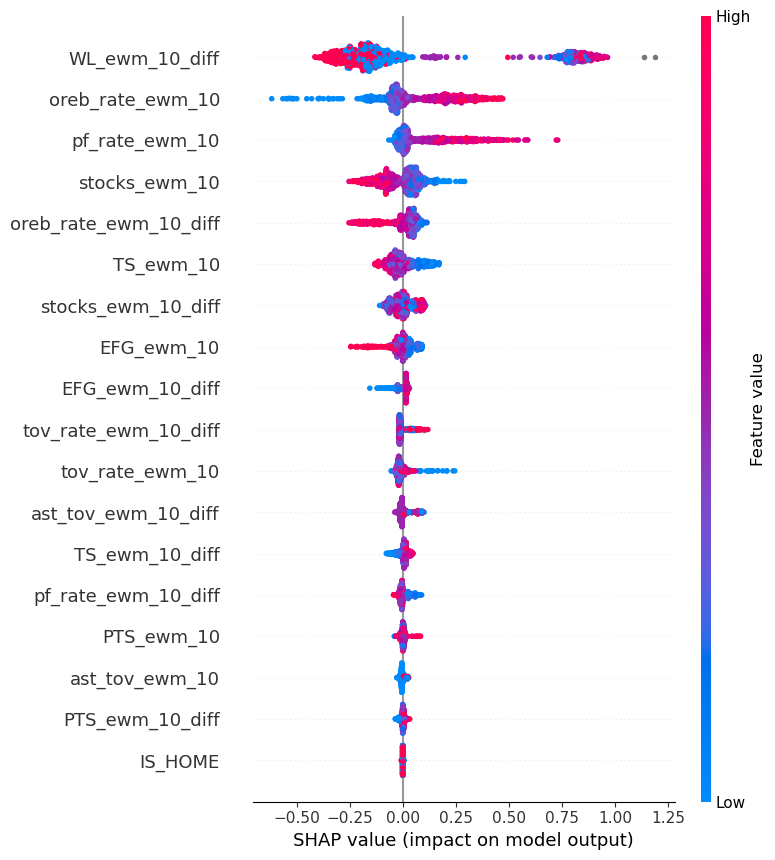

In [357]:
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_test)

shap.summary_plot(shap_vals, X_test)